## Setup

In [43]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit
from uncertainties import ufloat
from scipy.signal import find_peaks
from numpy.linalg import lstsq
import os
import glob
import time
import datetime
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

In [3]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

## Data Extraction

In [ ]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getRealImagData(data, buffer=10, num_blocks=2030):
    real_data = np.zeros((num_blocks, 1024), dtype=float)
    imag_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        #real_data[i] = normalize(block['corr01'].real)
        #imag_data[i] = normalize(block['corr01'].imag)
        real_data[i] = block['corr01'].real
        imag_data[i] = block['corr01'].imag
    return real_data, imag_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getHorizonRawData(folder, extension="npy"):
    # Load and merge many files
    directory = "ugastro\\Lab3Data\\" + folder
    file_paths = sorted(glob.glob(os.path.join(directory, f"*.{extension}")))
    if not file_paths:
        print("No files found. Check the directory path and file extension.")
        return None
    
    data = []
    for file in file_paths:
        try:
            data.append(np.load(file, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if data:
        merged_data = np.concatenate(data, axis=0)
        return merged_data
    else:
        print("No valid data files loaded.")
        return None

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getUnixTimes(data, buffer=10):
    # Takes raw data
    times = [(data[i+buffer]['time']) for i in range(len(data)-buffer)]

    return times

def getTimesJD(data, buffer=10):
    # Takes raw data
    times = [(data[i+buffer]['time']/86400)+2440587.5 for i in range(len(data)-buffer)]

    return times

def getTimesLocal(data):
    # Takes raw data
    times = [time.gmtime(data[i]['time']) for i in range(len(data))]
    return times

def timestepToSec(timestep):
    # Takes a time step in seconds and converts to a datetime object
    return 1.25 * timestep


In [5]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

data_horizon_raw_1 = extractRawData(folder, "Mar13_12hour_observation_data.npz")
data_horizon_1 = getDataBlocks(data_horizon_raw_1['arr_0'], )

data_horizon_raw_2 = getHorizonRawData("Mar15_Observation")
print(len(data_horizon_raw_2))
data_horizon_2 = normalize(getDataBlocks(data_horizon_raw_2, buffer=10, num_blocks=28700))

28720


In [6]:
print(data_horizon_raw_2)

[{'corr01': array([5.78389908+0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j]), 'acc_cnt': 594983, 'time': 1742052738.9676688}
 {'corr01': array([ 5.08669397-0.04343709j, -0.49739187+0.02401704j,
        -0.49225754-0.03869921j, ..., -0.46264089+0.0029751j ,
        -0.43924312-0.07771298j, -0.42370577-0.088981j  ]), 'acc_cnt': 594984, 'time': 1742052740.3374286}
 {'corr01': array([5.7490367+0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j]), 'acc_cnt': 594985, 'time': 1742052741.5707567}
 ...
 {'corr01': array([6.08720183+0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j]), 'acc_cnt': 623700, 'time': 1742088638.098983}
 {'corr01': array([5.99270642+0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j]), 'acc_cnt': 623701, 'time': 1742088639.3779454}
 {'corr01': array([5.84848624+0.j, 0.        +0.j, 0.  

In [7]:
horizon_real, horizon_imag = getRealImagData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(len(horizon_real))
print(len(horizon_imag))

28720
28720


c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


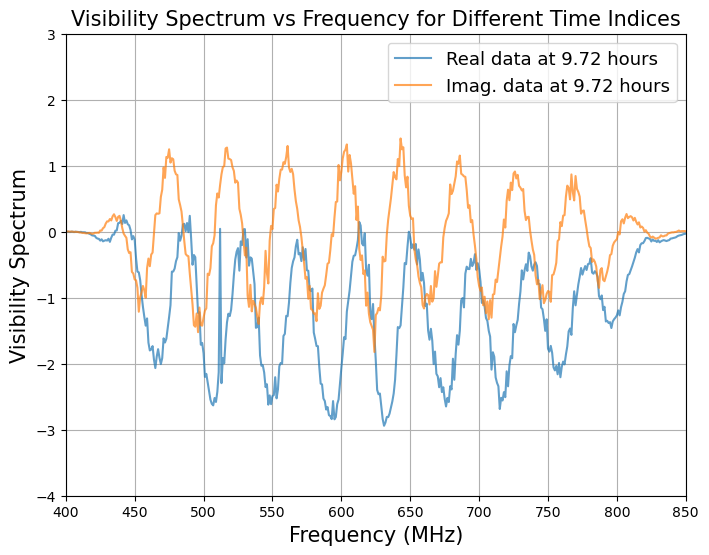

In [8]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    freqs = np.linspace(0, 500, len(data[0]))

    for index in indices:
        spectrum = data[index]
        plt.plot(spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

def plot_power_spectrum_complex(data_real, data_imag, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [(x*1.25)/3600 for x in range(len(data_real))]

    for index in indices:
        spectrum_real = data_real[index]
        spectrum_imag = data_imag[index]
        plt.plot(spectrum_real, label=f"Real data at {round(times[index], 2)} hours", alpha=0.7)
        plt.plot(spectrum_imag, label=f"Imag. data at {round(times[index], 2)} hours", alpha=0.7)

    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

#plot_power_spectrum(data_horizon_2, indices=[23000, 28000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[10000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[23000], xlim=(400, 850), ylim=(-4, 3))
plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[28000], xlim=(400, 850), ylim=(-4, 3))

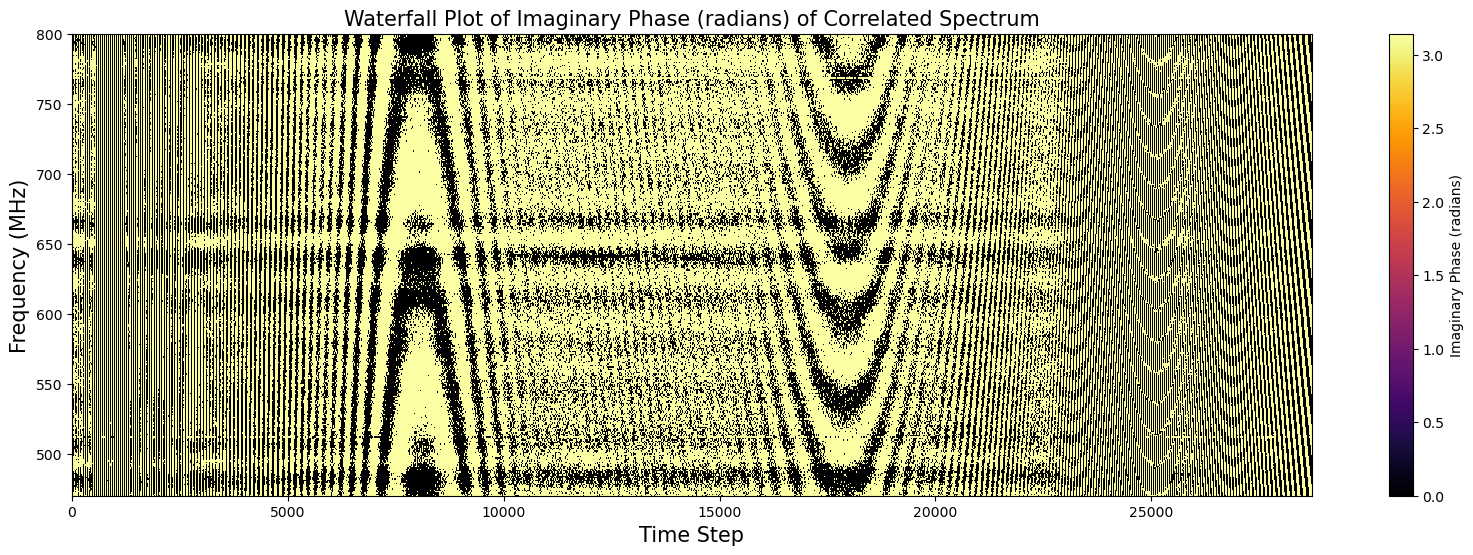

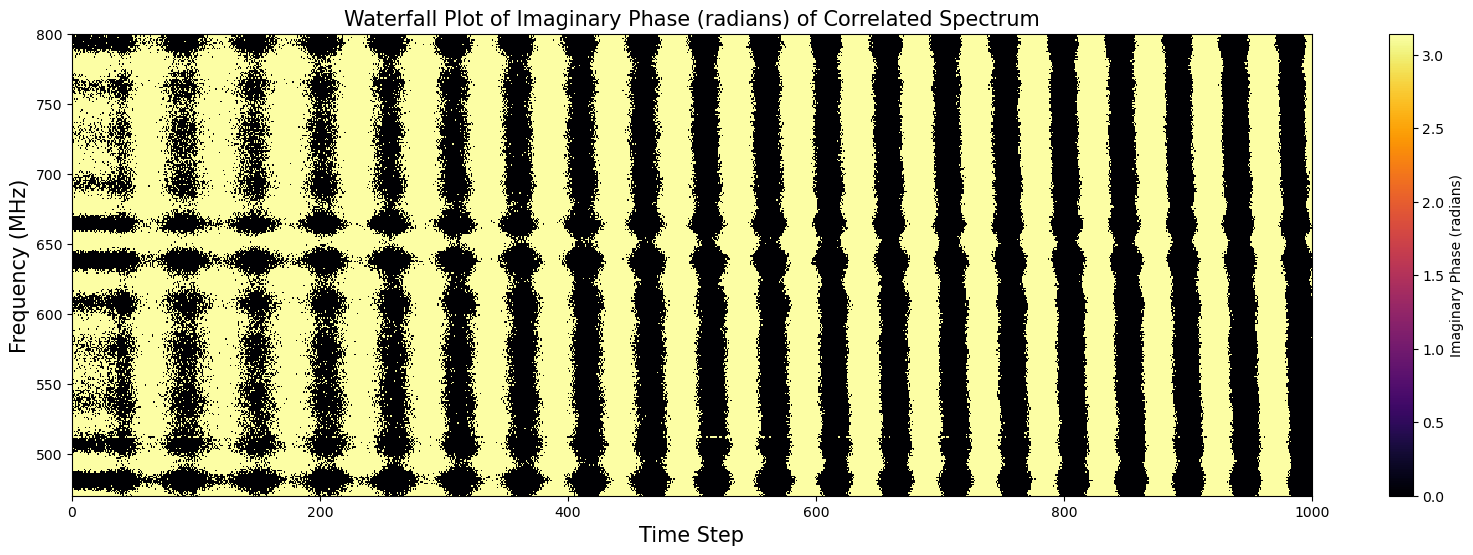

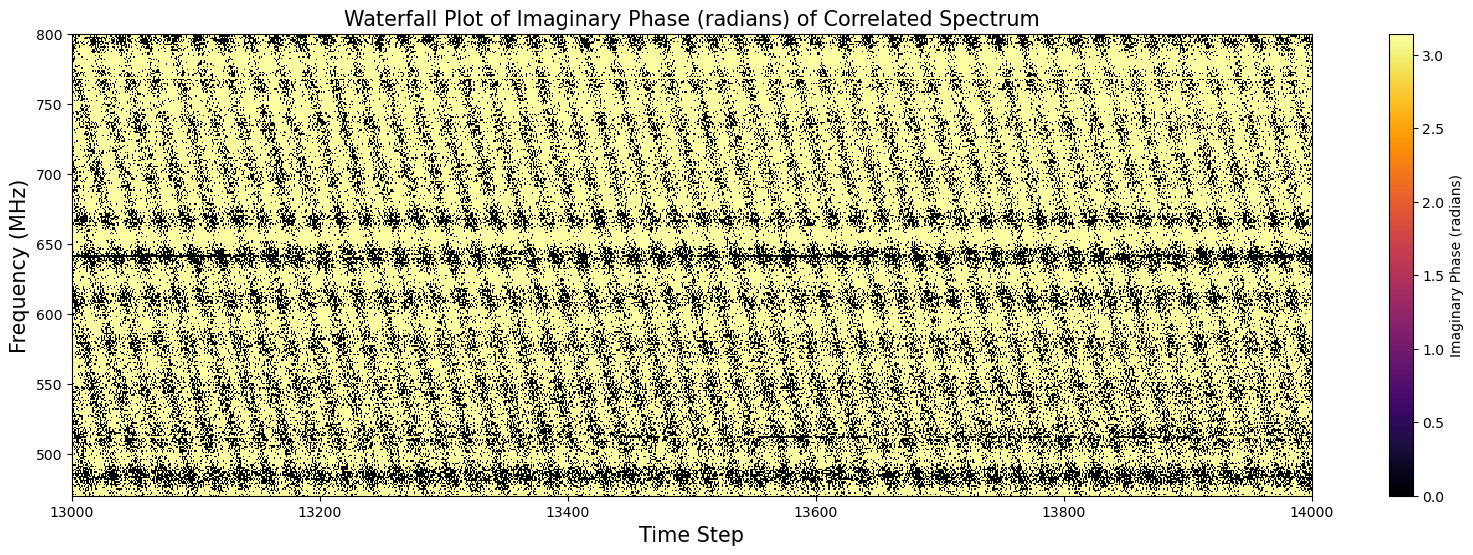

In [9]:
def plot_waterfall(data, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
                interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_any(data_real, data_imag, mode='real', xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)

    if mode == 'real':
        display_data = (data_real.T).astype(float)
        label = "Real Component"
    elif mode == 'imag':
        display_data = (data_imag.T).astype(float)
        label = "Imaginary Component"
    elif mode == 'phase (real)':
        display_data = (np.angle(data_real.T)).astype(float)
        label = "Real Phase (radians)"
    elif mode == 'phase (imag)':
        display_data = (np.angle(data_imag.T)).astype(float)
        label = "Imaginary Phase (radians)"
    else:
        raise ValueError(f"Unknown mode '{mode}'. Choose from 'real', 'imag', 'phase (real)', or phase (imag).")
    
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label=label)
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of {label} of Correlated Spectrum", size=titleSize)
    plt.show()


#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
#plot_waterfall_corr(data_test[:400], data_test_2[:400], xlim=(220, 400))
#plot_waterfall(data_horizon_2, xlim=(470, 800))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(0, 1000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(4000, 5000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(12500, 13000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(22000, 23000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(25000, 28600))

#plot_waterfall(horizon_real)
#plot_waterfall_any(horizon_real, horizon_imag, mode='real', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='imag', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (real)', ylim=(470, 800))
plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800))

plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(0, 1000))
plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(13000, 14000))

In [10]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], offset=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {offset+index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
#print(f"Peaks = {peaks[0]}")
#print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

#plot_time_delay(data_horizon_2, indices=[100, 500, 1000, 10000, 15000, 20000])
#plot_time_delay_corr(data_horizon_2[28000:28450], data_test_2[:450], indices=[100, 200, 300, 400], offset=28000, xlim=(0, 200))

In [11]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

def plot_phase_waterfall_complex(data_real, data_imag, real=True, xlim=None, ylim=None):
    phases = np.angle(data_real) if real else np.angle(data_imag)

    plt.figure(figsize=graphSizeSingle)
    #plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
    #           extent=[0, 1024, 0, data_real.shape[0]], interpolation='nearest',
    #           origin='lower')
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear', origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

#plot_phase_waterfall_complex(horizon_real, horizon_imag)
#plot_phase_waterfall_complex(horizon_real, horizon_imag, real=False)

#plot_phase_evolution(data_test[:450])
#plot_phase_evolution(data_horizon_2[28200:])
#plot_phase_waterfall(data_test[:450], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[2000:5000], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[28000:], xlim=(220, 400))

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


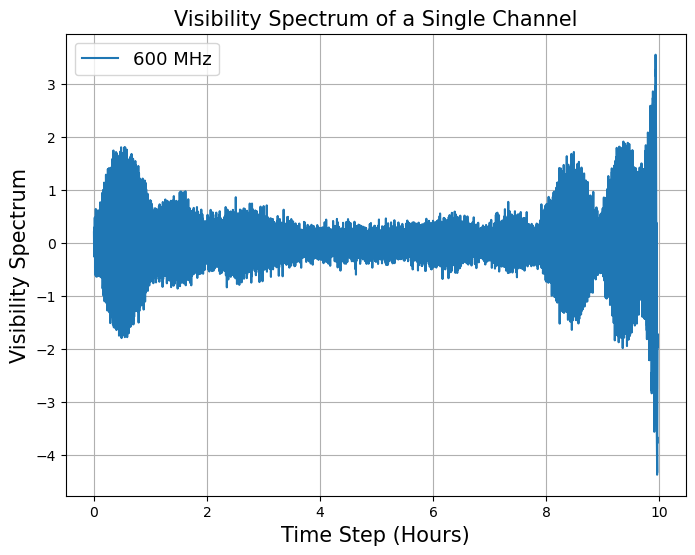

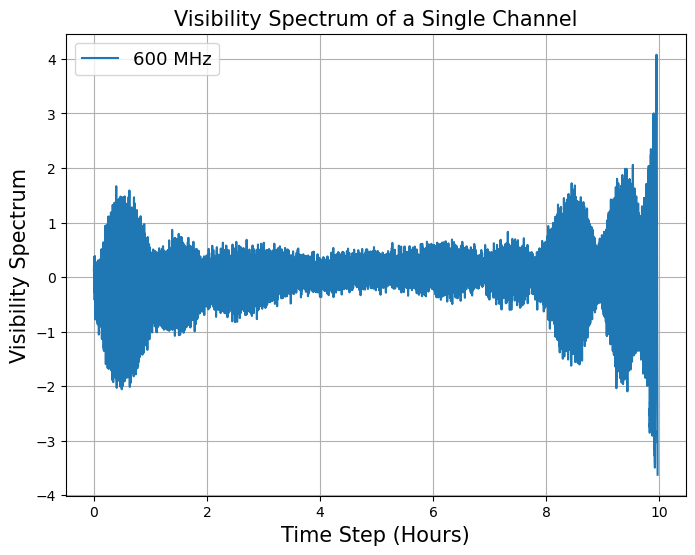

In [12]:
def graphSingleChannelOverTime(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    times = [(x*1.25)/3600 for x in range(len(data))]

    plt.plot(times, channel_data, label=f"{channel} MHz")
    plt.xlabel("Time Step (Hours)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum of a Single Channel", size=titleSize)
    plt.grid()
    plt.show()

graphSingleChannelOverTime(horizon_imag, channel=600)
graphSingleChannelOverTime(horizon_real, channel=600)

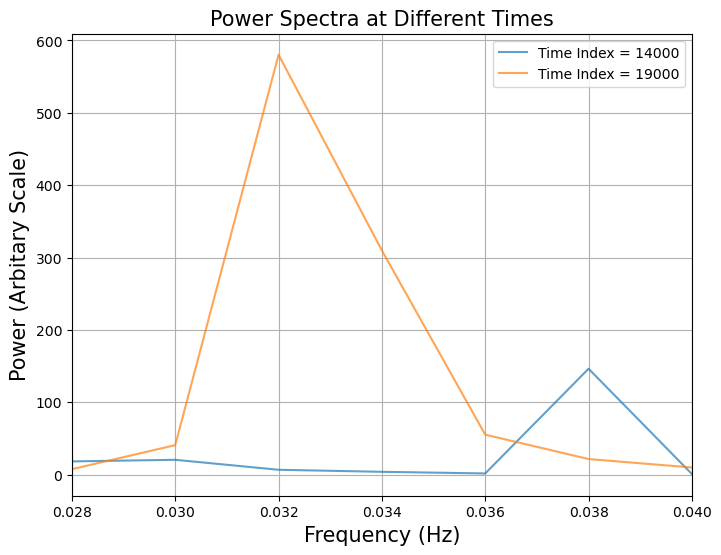

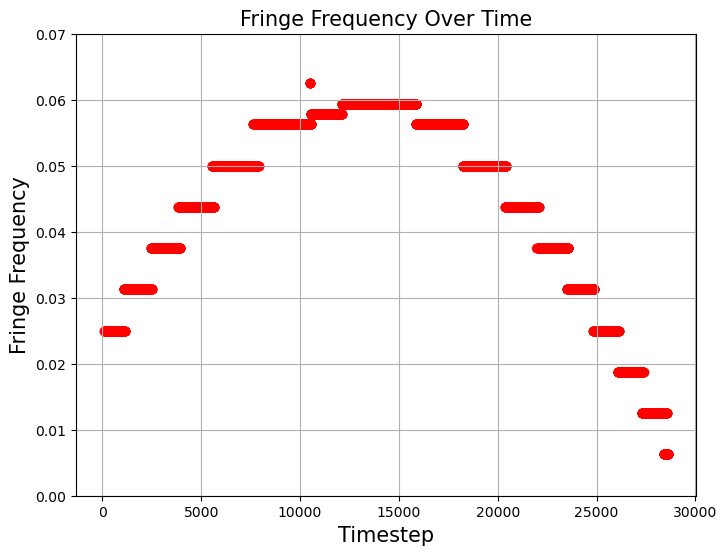

In [33]:
def graphOverlayPowerSpectra(data, sample_rate, channel=600, indices=[5000, 10000, 20000, 25000], window=100, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    for index in indices:
        spectrum = np.abs(fftshift(fft(channel_data[index-window:index+window]))) ** 2
        freqs = fftshift(fftfreq(len(spectrum), sample_rate))
        plt.plot(freqs, spectrum, label=f"Time Index = {index}", alpha=0.7)
   
    plt.xlim(xlim)
    plt.xlabel("Frequency (Hz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra at Different Times", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

def graphFringeFreqOverTime(data, sample_rate, channel=600, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    indices = np.linspace(101, len(channel_data) - 101, len(channel_data) - 202, dtype=int)
    max_freqs = np.zeros(len(channel_data) - 202)

    for i, index in enumerate(indices):
        if index > 11000 and index < 16000:
            window = 200
        else:
            window = 100

        spectrum = np.abs(fft(channel_data[index-window:index+window])) ** 2        
        freqs = fftfreq(len(spectrum), d=1/sample_rate)

        max_freqs[i] = freqs[np.argmax(spectrum)]

    # Accounting for weird vertical lines in data when it should be smooth
    max_freqs[10450:12000] = (np.abs(max_freqs[10400]) + np.abs(max_freqs[12150])) / 2
    max_freqs[14500:15500] = (max_freqs[14500] + max_freqs[15500]) / 2

    plt.scatter(indices, max_freqs, color='r', alpha=0.7)
   
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Fringe Frequency", fontsize=axisSize)
    plt.title(f"Fringe Frequency Over Time", size=titleSize)
    plt.grid(True)
    plt.show()

    return max_freqs

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[1000, 2000, 3000, 4000, 5000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[6000, 7000, 8000, 9000, 10000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[11000, 12000, 13000, 14000, 15000], window=200, channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[16000, 17000, 18000, 19000, 20000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[21000, 22000, 23000, 24000, 25000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[26000, 27000, 28000], channel=600, xlim=(0, 0.06))

graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[14000, 19000], window=200, channel=600, xlim=(0.028, 0.04))


fringe_freqs = graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, ylim=(0, 0.07))

In [48]:
time_data_jd = getTimesJD(data_horizon_raw_2)
time_data_utc = getTimesLocal(data_horizon_raw_2)
print("Started Mar 15, 8:32:19 AM PST")
print("Ended Mar 15, 6:30:41 PM PST")
print("Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)")
print("28720 time steps")
print("1.25 seconds per time step")

ra, dec = np.zeros(len(time_data_jd)), np.zeros(len(time_data_jd))
for i in range(len(time_data_jd)):
    ra[i], dec[i] = ugradio.coord.sunpos(time_data_jd[i])

print(f"max ra = {np.max(ra)}, min ra = {np.min(ra)}")
print(f"max dec = {np.max(dec)}, min dec = {np.min(dec)}")

Started Mar 15, 8:32:19 AM PST
Ended Mar 15, 6:30:41 PM PST
Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)
28720 time steps
1.25 seconds per time step
max ra = 355.73967807691713, min ra = 355.3597478130194
max dec = -1.8448678688410642, min dec = -2.0088630503882237


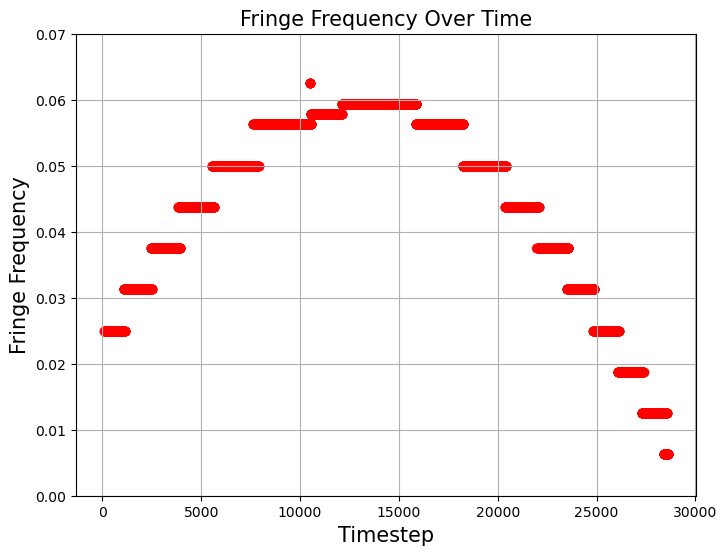

X shape: (28518, 2)
y shape: (28518,)
indices shape: (28518,)
timestep 0: observed = 0.025, estimated = 0.018934
timestep 2000: observed = 0.03125, estimated = 0.028564
timestep 4000: observed = 0.04375, estimated = 0.0372521
timestep 6000: observed = 0.05, estimated = 0.0447116
timestep 8000: observed = 0.05625, estimated = 0.0506967
timestep 10000: observed = 0.05625, estimated = 0.0550099
timestep 12000: observed = 0.059375, estimated = 0.0575089
timestep 14000: observed = 0.059375, estimated = 0.0581113
timestep 16000: observed = 0.05625, estimated = 0.0567971
timestep 18000: observed = 0.05625, estimated = 0.0536096
timestep 20000: observed = 0.05, estimated = 0.048654
timestep 22000: observed = 0.0375, estimated = 0.0420938
timestep 24000: observed = 0.03125, estimated = 0.0341451
timestep 26000: observed = 0.01875, estimated = 0.0250705
timestep 28000: observed = 0.0125, estimated = 0.0151685
b_ew = 20.499245439846153, b_ns = 1.912763531648717
b_ew = 20.499 ± 20.233 m
b_ns = 1.9

In [54]:
# 1000 = 3/15/25 8:48:59 AM PST
# 4000 = 3/15/25 9:39:19 AM PST
# 7000 = 3/15/25 10:22:40 AM PST
# 9000 = 3/15/25 11:39:49 AM PST 
# 14000 = 3/15/25 1:23:59 PM PST
# 19000 = 3/15/25 3:08:09 PM PST
# 24000 = 3/15/25 4:52:19 PM PST
# timesteps = [1000, 4000, 7000, 9000, 14000, 19000, 24000]
# jds = [time_data_jd[i] for i in timesteps]
# RAs = [np.radians(ra[i]) for i in timesteps]
# DECs = [np.radians(dec[i]) for i in timesteps]
# LSTs = [np.radians(288.4903), np.radians(301.1081), np.radians(311.9752), np.radians(331.3155), np.radians(357.4285), np.radians(23.5415), np.radians(49.654)] 
# HAs = [LSTs[i] - RAs[i] for i in range(len(RAs))]
# 
# observed_fringe_freqs = [abs(round(fringe_freqs[t], 5)) for t in timesteps]
# 
# w_earth = (2 * np.pi) / (24 * 60 * 60)
# wavelen = 0.025
# L = np.radians(37.873199)
# b_ew = 20
# b_ns = 0
# estimated_fringe_freqs = []
# for i, fringe in enumerate(timesteps):
#     Q_ew = (b_ew / wavelen) * np.cos(DECs[i])
#     Q_ns = (b_ns / wavelen) * np.sin(L) * np.cos(DECs[i])
#     estimated_fringe_freqs.append((Q_ew * np.cos(HAs[i]) - Q_ns * np.sin(HAs[i])) * w_earth)
# print(f"Observed fringe frequencies = {[round(ff, 5) for ff in observed_fringe_freqs]}")
# print(f"Estimated fringe frequencies = {[round(ff, 5) for ff in estimated_fringe_freqs]}")

fringe_freqs = graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, ylim=(0, 0.07))
indices = np.linspace(101, len(horizon_imag) - 101, len(horizon_imag) - 202, dtype=int)
observed_fringe_freqs = [abs(ff) for ff in fringe_freqs]
#print(f"Observed fringe frequencies = {[round(ff, 7) for ff in observed_fringe_freqs]}")

time_data = getUnixTimes(data_horizon_raw_2)
time_data_jd = getTimesJD(data_horizon_raw_2)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)

w_earth = (2 * np.pi) / (24 * 60 * 60)
wavelen = 0.025
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

HAs_slice = HAs[indices]
DECs_slice = DECs[indices]

A = (1 / wavelen) * np.cos(DECs_slice) * np.cos(HAs_slice)
B = -(1 / wavelen) * np.sin(L) * np.cos(DECs_slice) * np.sin(HAs_slice)
X = np.vstack([A, B]).T
y = np.array(observed_fringe_freqs) / w_earth

print("X shape:", X.shape)
print("y shape:", y.shape)
print("indices shape:", indices.shape)

estimated_fringe_freqs = []
#for i in range(time_data_jd):
#     Q_ew = (b_ew_guess / wavelen) * np.cos(DECs[i])
#     Q_ns = (b_ns_guess / wavelen) * np.sin(L) * np.cos(DECs[i])
#     estimated_fringe_freqs.append((Q_ew * np.cos(HAs[i]) - Q_ns * np.sin(HAs[i])) * w_earth)
Q_ew = (b_ew_guess / wavelen) * np.cos(DECs)
Q_ns = (b_ns_guess / wavelen) * np.sin(L) * np.cos(DECs)
estimated_fringe_freqs = (Q_ew * np.cos(HAs) - Q_ns * np.sin(HAs)) * w_earth
#print(f"Estimated fringe frequencies = {[round(ff, 7) for ff in estimated_fringe_freqs]}")
step = 2000
for i in range(0, len(observed_fringe_freqs), step):
    obs = round(observed_fringe_freqs[i], 7)
    est = round(estimated_fringe_freqs[i], 7)
    print(f"timestep {i}: observed = {obs}, estimated = {est}")


beta, residuals, rank, s = lstsq(X, y, rcond=None)
b_ew, b_ns = beta
print(f"b_ew = {b_ew}, b_ns = {b_ns}")

N, p = len(y), 2
sigma2 = np.sum(residuals**2) / (N - p)
cov = sigma2 * np.linalg.inv(X.T @ X)
errors = np.sqrt(np.diag(cov))
chi2_red = sigma2
print(f"b_ew = {b_ew:.3f} ± {errors[0]:.3f} m")
print(f"b_ns = {b_ns:.3f} ± {errors[1]:.3f} m")
print(f"Reduced chi-squared = {chi2_red:.3f}")

In [42]:
def compute_delta(jd_start, jd_end, num_time_steps):
    jds = np.linspace(jd_start, jd_end, num_time_steps)
    return [np.radians(ugradio.coord.sunpos(jds[i])[1]) for i in range(num_time_steps)]

def tau_g(h_s, b_ew, b_ns, delta, L, c=3e8):
    left_part = ((b_ew / c) * np.cos(delta)) * np.cos(h_s)
    right_part = (b_ns / c) * np.cos(L) * np.sin(delta)
    return left_part - right_part

def fringe_model(hs, A, B, freq, b_ew, b_ns, delta, L):
    # Eventually solving for A & B
    tau_g_vals = tau_g(hs, b_ew, b_ns, delta, L)
    left_part = A * np.cos(2 * np.pi * freq * tau_g_vals)
    right_part = B * np.sin(2 * np.pi * freq * tau_g_vals)
    return left_part + right_part

def compute_local_fringe_freq(data):
    time_steps = np.arange(data.shape[0])
    phase = np.unwrap(np.angle(data))
    fringe_freq = np.gradient(phase, time_steps) / (2 * np.pi)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe_freq, label="Local Fringe Frequency", color='r')
    plt.xlabel('Time Steps', fontsize=axisSize)
    plt.ylabel('Frequency (Hz)', fontsize=axisSize)
    plt.title('Computed Local Fringe Frequency', size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show

    return fringe_freq

def fit_least_squares(data, b_ew, b_ns, dec, fringe_freq, L, xlim=None, ylim=None):
    time_steps = np.arange(data.shape[0])
    fringe = np.abs(data)

    tau_g_vals = tau_g(time_steps, b_ew, b_ns, dec, L)

    # Design matrix
    X = np.column_stack([np.cos(2 * np.pi * tau_g_vals), np.sin(2 * np.pi * tau_g_vals)])
    beta, residuals, _, _ = np.linalg.lstsq(X, fringe, rcond=None)
    A, B = beta

    fringe_amplitude = np.sqrt(A**2 + B**2)
    fitted_phase = np.arctan2(B, A)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe, label="Measured Fringe")
    plt.plot(time_steps, fringe_model(time_steps, A, B, fringe_freq, b_ew, b_ns, dec, L), 
            label="Fitted Fringe", linestyle='dashed')

    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Fringe Amplitude (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Least Squares Fitting of Fringe Amplitude", size=titleSize)
    plt.grid()
    plt.show()

    return fringe_amplitude, fitted_phase, beta, residuals

b_ew = 20
b_ns = 0
dec = -0.03416507529584909
ha = -0.4217280392519642
fringe_freq = 0.05625
wavelen = 0.025
w_earth = (2 * np.pi) / (24 * 60 * 60)
L = np.radians(37.873199)

A = (1 / wavelen) * np.cos(dec) * np.cos(ha)
B = -(1 / wavelen) * np.sin(L) * np.cos(dec) * np.sin(ha)

lhs = fringe_freq / w_earth
X = np.array([[A, B]])
y = np.array([lhs])

[b_ew_fit, b_ns_fit], residuals, rank, s = lstsq(X, y, rcond=None)

print(f"Fit results:")
print(f"b_ew = {b_ew_fit:.3f} m")
print(f"b_ns = {b_ns_fit:.3f} m")

Fit results:
b_ew = 19.711 m
b_ns = 5.429 m


NOTES:  

dont do absolute value, keep real and complex data and find way to fix systematics (misalignment)?

waterfall plot for angle flip axes

non perfect bessel func bc not perfect disk (sun spot delta -> (FFT) -> flat function / baseline instead of 0)